###Ejemplo de utilización de python en data analytics : Global land temperature evolution
###### Computación 3 - Daiana Dominikow - primera clase 2022

#####Importo librerías!

In [0]:
#pyspark es una librería que utiliza spark como motor de cómputo en clusters, se utiliza en el manejo iterativo de grandes cantidades de datos dado a su performance frente a métodos clásicos de procesamiento como MapReduce

#documentación: https://spark.apache.org/docs/3.1.1/api/python/reference/pyspark.sql.html#functions
import pyspark.sql.functions as func
from pyspark.sql.types import IntegerType
from pyspark.sql import SparkSession

#lo PRIMERO que tengo que hacer, es crear una sesión de spark, es decir, inicializar de alguna manera este framework, que me vá a permitir trabajar con queries estilo HIVE (SQL, no se asusten) para un manejo mas copado de la iformación
spark=SparkSession.builder.appName("Climate").getOrCreate()

In [0]:
#pandas es una librería basada en numpy, la cual se utiliza para manipulación de vectores y matrices de datos, que organiza en filas y columnas nuestra información en dataframes, dandole un formato "tabla", pero no procesa tanta cantidad de datos como  sí lo hace spark, con lo cual acá lo voy a utilizar con la data ya "agregada", es decir, previamente digerida en pyspark para plotear la informaciòn.

#una diferencia fundamental es que pandas trabaja la data en memoria local, mientras que pyspark en clusters (distribuidos en servidores), haciendo mas eficiente el laburo
import pandas as pd

In [0]:
#para "plotear" gráficamente la información que quiero analizar o mostrar y darle colores
#documentación: https://matplotlib.org/3.4.3/gallery/index.html
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

##### Levanto el dataset

In [0]:
# La data puede estar en una base de datos, en un archivo .txt, en un .csv, hay maneras de levantar con una api información en vivo desde una página de internet, es indistinto. Para este caso, y dado que estoy trabajando con Community DataBricks (donde puedo utilizar SPARK de manera gratuita), la única opción que tengo es trabajar con un archivo que cargo previamente en un directorio propio de la página.
# voy a levantar el dataset a un DataFrame, que es una estructura de datos que replica una tabla con filas y columnas

df = spark.read.csv("dbfs:/FileStore/Climate/GlobalLandTemperaturesByCountry.csv",inferSchema=True,header=True)

##### Mostrar información sobre el DataFrame

In [0]:
#Veo las columnas del dataframe creado
df.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- Country: string (nullable = true)



In [0]:
#Cuento la cantidad de registros para darme una idea de lo que estoy trabajando
df.count()


Out[6]: 577462

##### Visualizar datos

In [0]:
#Si quisiera visualizar por ejemplo el promedio de temperaturas agrupado por año
#Columna agrupadora : dt
#Columna medible : AverageTemperature

#puedo hacerlo de dos maneras:


In [0]:
#a. utilizando las funciones de pyspark

df.groupBy(func.year("dt").alias("year")).agg(func.round(func.avg("AverageTemperature"),2).alias("avg temp")).sort(func.desc("year")).show(20)

+----+--------+
|year|avg temp|
+----+--------+
|2013|   19.88|
|2012|   19.47|
|2011|   19.46|
|2010|   19.63|
|2009|   19.55|
|2008|   19.42|
|2007|   19.61|
|2006|   19.54|
|2005|    19.5|
|2004|   19.42|
|2003|   19.53|
|2002|   19.57|
|2001|   19.43|
|2000|   19.35|
|1999|   19.39|
|1998|    19.6|
|1997|   19.25|
|1996|   18.96|
|1995|   19.27|
|1994|   19.25|
+----+--------+
only showing top 20 rows



In [0]:
#b. Utilizando el lenguaje SQL admitido por pyspark (Hive)

#primero creo una tabla temporal
df.createOrReplaceTempView("climate")

spark.sql("SELECT year(c.dt) as year, round(avg(c.AverageTemperature),2)  as avg_temp FROM climate c group by year(c.dt)  order by year(c.dt) desc").show()

+----+--------+
|year|avg_temp|
+----+--------+
|2013|   19.88|
|2012|   19.47|
|2011|   19.46|
|2010|   19.63|
|2009|   19.55|
|2008|   19.42|
|2007|   19.61|
|2006|   19.54|
|2005|    19.5|
|2004|   19.42|
|2003|   19.53|
|2002|   19.57|
|2001|   19.43|
|2000|   19.35|
|1999|   19.39|
|1998|    19.6|
|1997|   19.25|
|1996|   18.96|
|1995|   19.27|
|1994|   19.25|
+----+--------+
only showing top 20 rows



#### Plotear la información!

In [0]:
# armo  un data frame agrupado con la infoemación que necesito
year_temp = (df.groupBy(func.year("dt").cast(IntegerType()).alias("year"))
               .agg(func.round(func.avg("AverageTemperature"),2).alias("avg_temp"))
               .sort(func.asc("year")))


######primer gráfico

In [0]:
# para el primer gráfico, voy a asegurarme de que mi columna year sea numérica para filtrar esta data y mostrar solo el promedio de las temperaturas desde el año 1900
df_1 = (year_temp.withColumn("year",year_temp.year.cast(IntegerType()))
                 .filter(year_temp['year']>=1900))

#esta función me muestra los tipos de dato de mis columnas
df_1.printSchema()

root
 |-- year: integer (nullable = true)
 |-- avg_temp: double (nullable = true)



In [0]:
# ahora, si quisiera graficar un evolutivo con esta información, tengo que volcarla en un dataframe de pandas, ya que hacerlo con pyspark es bastante mas complejo (y no recuerdo en el aire como hacerlo)
# pero antes de esto, lo primero es armar una lista a modo de eje, en X voy a poner el año:

year_list= df_1.select('year').collect()
year = [i.year for i in year_list]
#para ver mi lista
year


Out[12]: [1900,
 1901,
 1902,
 1903,
 1904,
 1905,
 1906,
 1907,
 1908,
 1909,
 1910,
 1911,
 1912,
 1913,
 1914,
 1915,
 1916,
 1917,
 1918,
 1919,
 1920,
 1921,
 1922,
 1923,
 1924,
 1925,
 1926,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1939,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013]

In [0]:
#para poder utilizar la librería MATPLOTLIB para plotear el gráfico, tengo que convertir mi dataframe a pandas
dfpd_1= df_1.toPandas()


##### ploteo el gráfico evolutivo del promedio de la temperatura por año :)

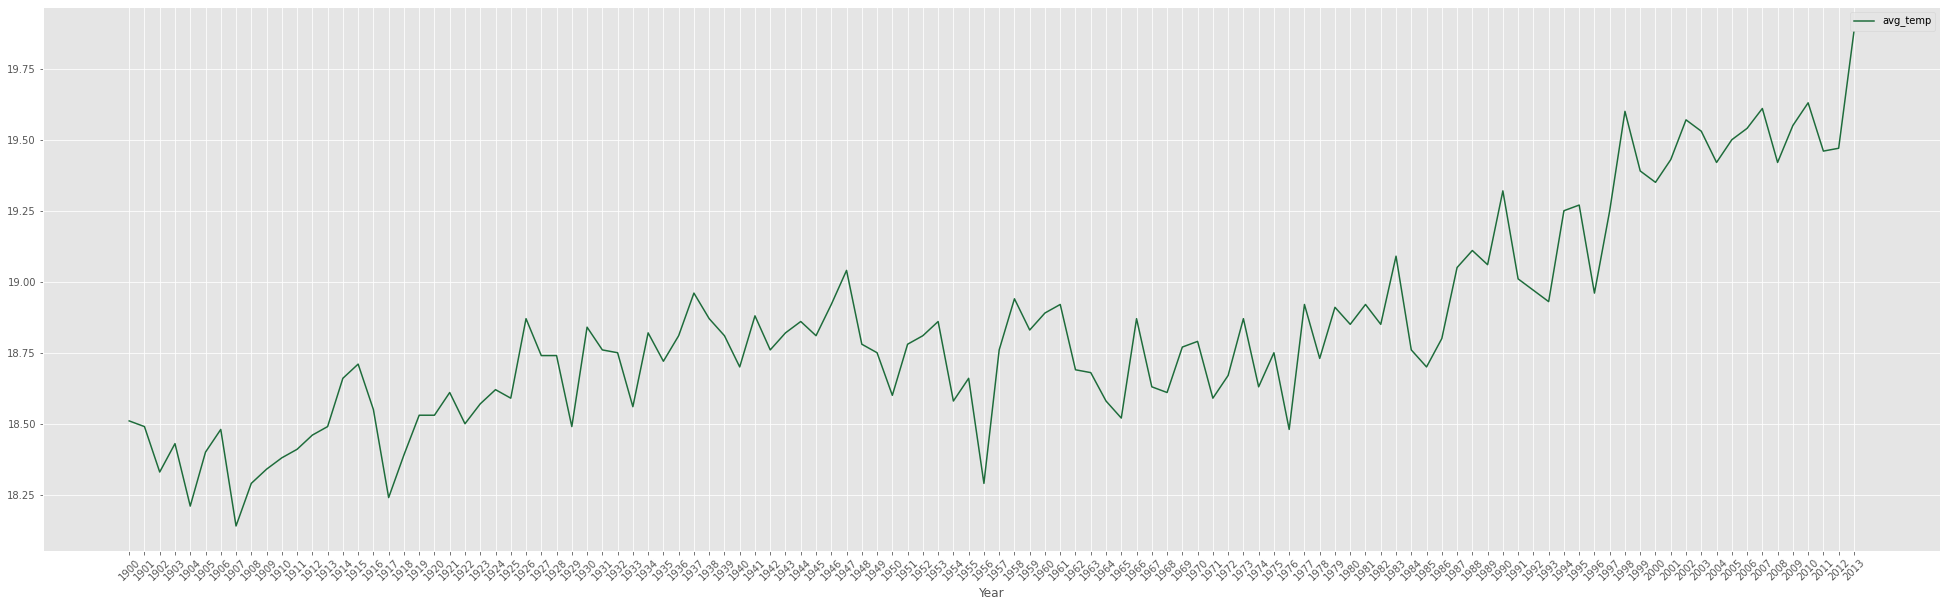

In [0]:
#seteo los parámetros de los gráficos a plotear, documentación: https://matplotlib.org/stable/tutorials/introductory/customizing.html
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (34, 10) #para darle tamaño a los gráfico

dfpd_1.plot(x="year", y=["avg_temp"], color = ["#1e6c3b"])
plt.xlabel("Year")
plt.xticks(year,rotation=45)  #meto la lista que armé a modo de eje
plt.show()

In [0]:
# para un análsis mas exaustivo, si quisieramos dividir por décadas y así incluir periodos anteriores

df_2=(year_temp.withColumn("decade", (func.floor(func.col("year")/10)*10)
               .cast(IntegerType()))
               .groupBy("decade")
               .agg(func.round(func.avg("avg_temp"),2).alias("avg_temp"))
               .sort(func.asc("decade"))
               )


In [0]:
#siempre chequeo que todo haya salido bien
df_2.show(200)

+------+--------+
|decade|avg_temp|
+------+--------+
|  1740|    5.47|
|  1750|    8.45|
|  1760|    8.46|
|  1770|    8.72|
|  1780|    8.94|
|  1790|   10.36|
|  1800|   10.48|
|  1810|    9.83|
|  1820|   13.11|
|  1830|   11.28|
|  1840|   14.04|
|  1850|   16.61|
|  1860|   16.68|
|  1870|   17.29|
|  1880|   17.83|
|  1890|   18.28|
|  1900|   18.36|
|  1910|   18.48|
|  1920|   18.63|
|  1930|   18.79|
|  1940|   18.83|
|  1950|   18.71|
|  1960|   18.72|
|  1970|   18.73|
|  1980|   18.92|
|  1990|    19.2|
|  2000|   19.49|
|  2010|   19.61|
+------+--------+



In [0]:
dfpd_2= df_2.filter(df_2.avg_temp.isNotNull()).filter(df_2.decade >= 1600).toPandas()
decade_list= df_2.filter(df_2.decade >= 1600).select('decade').collect()
decade = [i.decade for i in decade_list]

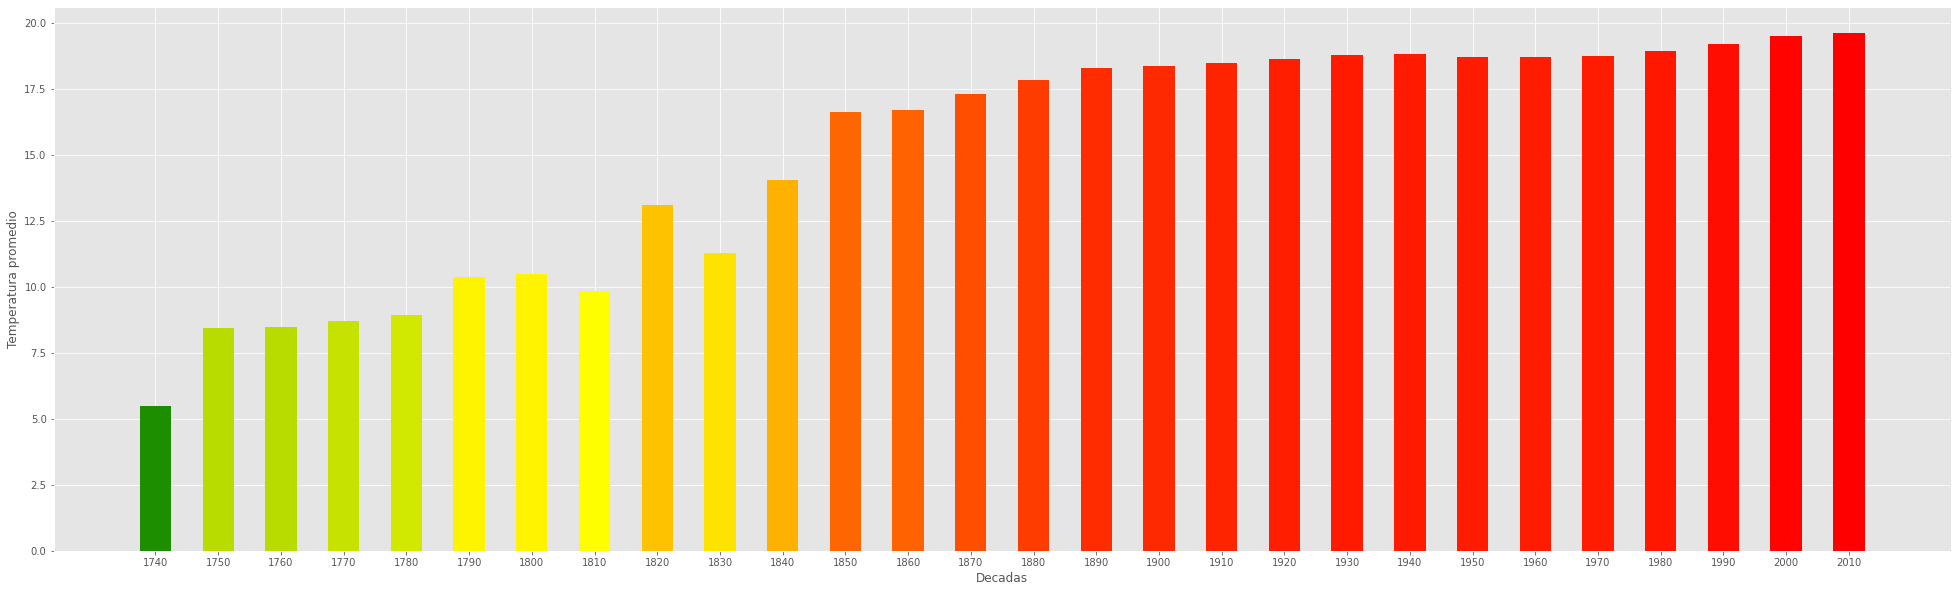

In [0]:
#para éste segundo gráfico, voy a utilizar un histograma, como para hacer uno distinto (?)


cmap = mcolors.LinearSegmentedColormap.from_list("", ["cyan","green", "yellow","orange","red"])

plt.bar(dfpd_2.decade,dfpd_2.avg_temp,5,color=cmap(dfpd_2.avg_temp.values/dfpd_2.avg_temp.values.max()))
plt.xlabel("Decadas")
plt.ylabel("Temperatura promedio")
plt.xticks(decade)

plt.show()

#podemos finalmente observar un crecimiento abismal de las temperaturas en el correr de las décadas.